In [1]:
import os
import numpy as np
import keras
import matplotlib.pyplot as plt
import pandas as pd
import time

from skimage.transform import resize
from keras.models import Model
from keras import layers, models
from keras import backend as K
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
from sklearn.model_selection import train_test_split, StratifiedKFold
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from tqdm import tqdm_notebook

Using TensorFlow backend.


In [2]:
K.set_image_data_format('channels_last')  # TF dimension ordering in this code

create_image_rows = 420
create_image_cols = 580

smooth = 1.0

In [3]:
image_t = np.load('./image_T.npy')
mask_t = np.load('./mask_T.npy')

suffle_seed = 42

In [4]:
def lee_filter(img, size):
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output

In [5]:
def SRAD(img, niter, lamda, rect):
    # make image a double and normalize on[0, 1]
    img = img.astype('double')
    mx = np.max(img[:])
    mn = np.min(img[:])
    img = (img-mn)/(mx-mn)

    # make image a double and normalize on[0, 1]
    [M, N] = np.shape(img)

    # image indices (using boudary conditions)
    iN = np.hstack((np.array(1), np.arange(1, M)))
    iS = np.hstack((np.arange(2, M), np.array(M-1), np.array(M-1)))
    jW = np.hstack((np.array(1), np.arange(1, N)))
    jE = np.hstack((np.arange(2, N), np.array(N-1), np.array(N-1)))

    # log uncompress (also eliminates zero value pixels)
    img = np.exp(img)

    # main algorithm
    for liter in np.arange(1, niter+1):

         # speckle scale function
        Iuniform = img[rect[0]:rect[1], rect[2]:rect[3]]
        q0_squared = np.var(Iuniform[:]) / (pow(np.mean(Iuniform[:]), 2))

        # difference
        dN = img[iN, :] - img
        dS = img[iS, :] - img
        dW = img[:, jW] - img
        dE = img[:, jE] - img

        # normalized discrete gradient magnitude squared (equ 52,53)
        G2 = (pow(dN, 2) + pow(dS, 2) + pow(dW, 2) + pow(dE, 2)) / pow(img, 2)

        # normalized discrete laplacian (equ 54)
        L = (dN + dS + dW + dE)/img

        # ICOV (equ 31/35)
        num = (0.5*G2) - ((1/16)*(pow(L, 2)))
        den = pow((1 + ((1/4)*L)), 2)
        q_squared = num / (den + np.finfo(float).eps)

        # diffusion coefficent (equ 33)
        den = (q_squared - q0_squared) / (q0_squared *
                                          (1 + q0_squared) + np.finfo(float).eps)
        c = 1 / (1 + den)

        # saturate diffusion coefficent
        c[c < 0] = 0
        c[c > 1] = 1

        # divergence (equ 58)
        cS = c[iS, :]
        cE = c[:, jE]
        D = (c*dN) + (cS*dS) + (c*dW) + (cE*dE)

        # update
        img = img + (lamda/4)*D

    J = np.log(img)
    return J

In [6]:
train_image_rows = 96
train_image_cols = 96

def preprocess_msk(imgs):
    imgs_p = np.ndarray(
        (imgs.shape[0], train_image_rows, train_image_cols), dtype=np.uint8)
    for i in tqdm_notebook(range(imgs.shape[0])):
        imgs_p[i] = resize(
            imgs[i].astype('float32'), (train_image_rows, train_image_cols), mode='reflect',
            preserve_range=True)

    imgs_p = imgs_p[..., np.newaxis]
    return imgs_p


def preprocess_img(imgs):
    imgs_p = np.ndarray(
        (imgs.shape[0], train_image_rows, train_image_cols), dtype=np.float32)
    for i in tqdm_notebook(range(imgs.shape[0])):
        #imgs[i] = SRAD(imgs[i], 30, 2, [50, 450, 50, 550])
        imgs[i] = lee_filter(imgs[i],11)
        imgs_p[i] = resize(
            imgs[i].astype('float32'), (train_image_rows, train_image_cols), mode='reflect', preserve_range=True)
        mean = np.mean(imgs_p[i])
        std = np.std(imgs_p[i])

        imgs_p[i] -= mean
        imgs_p[i] /= std

    imgs_p = imgs_p[..., np.newaxis]
    return imgs_p

In [7]:
image_c = preprocess_img(image_t)
mask_c = preprocess_msk(mask_t)

mask_c = mask_c .astype('float32')
mask_c /= 255.  # scale masks to [0, 1]

e:\program files\python36\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [8]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [9]:
def get_unet():
    inputs = layers.Input((train_image_rows, train_image_cols, 1))
    conv1 = layers.Conv2D(32, (3, 3),
                          activation='relu', padding='same')(inputs)
    conv1 = layers.Dropout(0.5)(conv1)
    conv1 = layers.Conv2D(32, (3, 3),
                          activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Dropout(0.5)(conv2)
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(128, (3, 3), activation='relu',
                          padding='same')(pool2)
    conv3 = layers.Dropout(0.5)(conv3)
    conv3 = layers.Conv2D(128, (3, 3), activation='relu',
                          padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(256, (3, 3), activation='relu',
                          padding='same')(pool3)
    conv4 = layers.Dropout(0.5)(conv4)
    conv4 = layers.Conv2D(256, (3, 3), activation='relu',
                          padding='same')(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = layers.Conv2D(512, (3, 3),
                          activation='relu', padding='same')(pool4)
    conv5 = layers.Dropout(0.5)(conv5)
    conv5 = layers.Conv2D(512, (3, 3), activation='relu',
                          padding='same')(conv5)

    up6 = layers.concatenate([layers.Conv2DTranspose(256, (2, 2), strides=(
        2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = layers.Dropout(0.5)(conv6)
    conv6 = layers.Conv2D(256, (3, 3), activation='relu',
                          padding='same')(conv6)

    up7 = layers.concatenate([layers.Conv2DTranspose(128, (2, 2), strides=(
        2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = layers.Dropout(0.5)(conv7)
    conv7 = layers.Conv2D(128, (3, 3), activation='relu',
                          padding='same')(conv7)

    up8 = layers.concatenate([layers.Conv2DTranspose(64, (2, 2), strides=(
        2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = layers.Dropout(0.5)(conv8)
    conv8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = layers.concatenate([layers.Conv2DTranspose(32, (2, 2), strides=(
        2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = layers.Dropout(0.5)(conv9)
    conv9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=keras.optimizers.Adam(lr=.0001),
                  loss=dice_coef_loss, metrics=[dice_coef])
    return model

In [10]:
unet = get_unet()
print((unet.summary()))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 96, 96, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 96, 96, 32)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)    

In [11]:
from sklearn.model_selection import StratifiedKFold
folds = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=42).split(image_c[:,0,0], mask_c[:,0,0]))

In [12]:
def get_callbacks(name_weights, patience_lr):
    mcp_save = ModelCheckpoint(
        name_weights, save_best_only=True, monitor='val_loss', mode='min')
    reduce_lr_loss = ReduceLROnPlateau(
        monitor='val_loss', factor=0.1, patience=patience_lr, verbose=1, min_delta=1e-5, mode='min')
    early_stopping = EarlyStopping(
        monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

    tb_hist = TensorBoard(log_dir='./logs',
                          histogram_freq=0, write_grads=True, write_images=True)
    return [mcp_save, reduce_lr_loss, early_stopping, tb_hist]

In [13]:
for j, (train_idx, val_idx) in enumerate(folds):
    now = time.localtime()
    s = "%02d-%02d-%02d_%02d;%02d" % (now.tm_year-2000,
                                      now.tm_mon, now.tm_mday, now.tm_hour, now.tm_min)
    #unet = get_unet()
    print('\nFold ', j)
    image_train_cv = image_c[train_idx]
    mask_train_cv = mask_c[train_idx]
    image_valid_cv = image_c[val_idx]
    mask_valid_cv = mask_c[val_idx]

    name_weights = "./final_model_fold" + \
        str(j) + "_weights.h5"
    callbackk = get_callbacks(name_weights=name_weights, patience_lr=10)

    history = unet.fit(image_train_cv, mask_train_cv, epochs=20, verbose=2, shuffle=True, validation_data=(
        image_valid_cv, mask_valid_cv), batch_size=32, callbacks=callbackk)
    df = pd.DataFrame({"loss": history.history['loss'],
                       "val_loss": history.history['val_loss'],
                       "dice_coef": history.history['dice_coef'],
                       "val_dice_coef": history.history['val_dice_coef']})
    df.to_csv(
        './history_{:2.3}_{}.csv'.format(history.history['val_dice_coef'][-1], s))
    print(unet.evaluate(image_valid_cv, mask_valid_cv, verbose=2))


Fold  0
Train on 1858 samples, validate on 465 samples
Epoch 1/20
 - 11s - loss: -6.8876e-02 - dice_coef: 0.0689 - val_loss: -1.4501e-01 - val_dice_coef: 0.1450
Epoch 2/20
 - 6s - loss: -3.9026e-01 - dice_coef: 0.3903 - val_loss: -2.3800e-01 - val_dice_coef: 0.2380
Epoch 3/20
 - 6s - loss: -5.6917e-01 - dice_coef: 0.5692 - val_loss: -3.9020e-01 - val_dice_coef: 0.3902
Epoch 4/20
 - 6s - loss: -6.3156e-01 - dice_coef: 0.6316 - val_loss: -5.6512e-01 - val_dice_coef: 0.5651
Epoch 5/20
 - 6s - loss: -6.5273e-01 - dice_coef: 0.6527 - val_loss: -6.2877e-01 - val_dice_coef: 0.6288
Epoch 6/20
 - 6s - loss: -6.6576e-01 - dice_coef: 0.6658 - val_loss: -6.3081e-01 - val_dice_coef: 0.6308
Epoch 7/20
 - 6s - loss: -6.8029e-01 - dice_coef: 0.6803 - val_loss: -6.4155e-01 - val_dice_coef: 0.6415
Epoch 8/20
 - 6s - loss: -6.9576e-01 - dice_coef: 0.6958 - val_loss: -6.9808e-01 - val_dice_coef: 0.6981
Epoch 9/20
 - 6s - loss: -7.1142e-01 - dice_coef: 0.7114 - val_loss: -7.0340e-01 - val_dice_coef: 0.703

Epoch 7/20
 - 6s - loss: -8.1923e-01 - dice_coef: 0.8192 - val_loss: -8.3896e-01 - val_dice_coef: 0.8390
Epoch 8/20
 - 6s - loss: -8.1991e-01 - dice_coef: 0.8199 - val_loss: -8.3910e-01 - val_dice_coef: 0.8391
Epoch 9/20
 - 6s - loss: -8.2005e-01 - dice_coef: 0.8200 - val_loss: -8.3901e-01 - val_dice_coef: 0.8390
Epoch 10/20
 - 6s - loss: -8.1870e-01 - dice_coef: 0.8187 - val_loss: -8.3867e-01 - val_dice_coef: 0.8387
Epoch 11/20
 - 6s - loss: -8.2035e-01 - dice_coef: 0.8204 - val_loss: -8.3868e-01 - val_dice_coef: 0.8387

Epoch 00011: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Epoch 00011: early stopping
[-0.8386777659942364, 0.8386777659942364]


In [28]:
mask_predict = unet.predict(image_valid_cv, verbose=1)

464/464 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step


In [29]:
mask_r = mask_predict.reshape(464, 96, 96)
mask_test_u = mask_valid_cv.reshape(464, 96, 96)
image_test_u = image_valid_cv.reshape(464, 96, 96)

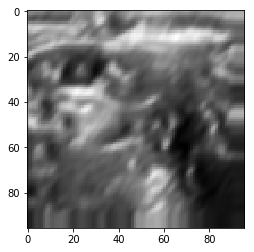

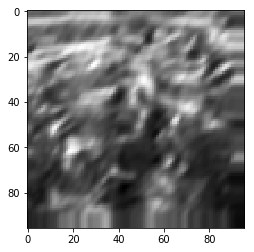

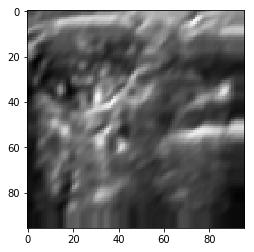

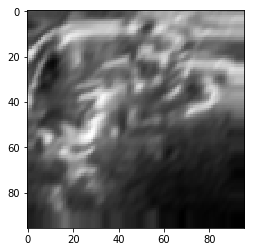

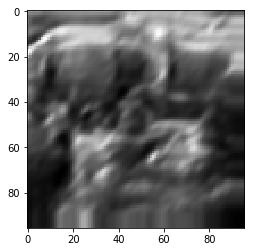

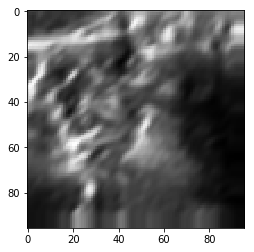

In [30]:
for i in np.arange(0,101,20):
    plt.figure()
    plt.imshow(image_test_u [i], cmap='gray')
    plt.show()

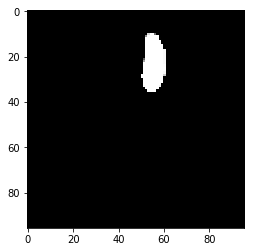

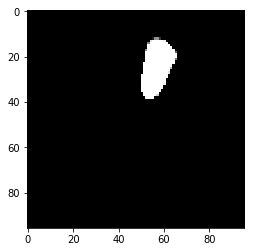

In [31]:
plt.figure()
plt.imshow(mask_test_u[100], cmap='gray')
plt.show()

plt.figure()
plt.imshow( mask_r[100], cmap='gray')
plt.show()

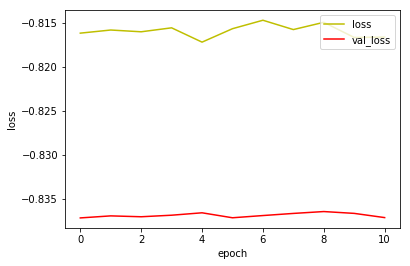

In [19]:
plt.plot(history.history['loss'], 'y', label='loss')
plt.plot(history.history['val_loss'], 'r', label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.show()

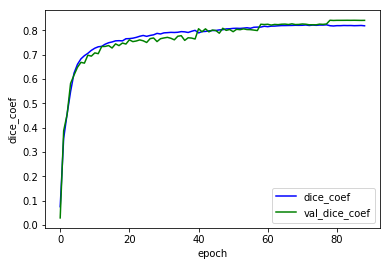

In [58]:
plt.plot(dice_coef, 'b', label='dice_coef')
plt.plot(val_dice_coef, 'g', label='val_dice_coef')
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.legend(loc='lower right')
plt.show()

In [17]:


df = pd.DataFrame({"loss": loss,  "val_loss": val_loss,
                   "dice_coef": dice_coef,  "val_dice_coef": val_dice_coef, })
df.to_csv('./history_{:2.3}.csv'.format(history.history['val_dice_coef'][-1]))